In [142]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from os import path
import matplotlib.pyplot as plt

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [144]:
# 1. Load data and drop leakage columns (assuming df is loaded already)
df = pd.read_csv(path.join('dataset', 'EVSE-B-HPC-Kernel-Events-processed.csv'))
corr = df.corr()
leak_cols = [col for col in corr['isDoS'].index if (corr['isDoS'][col] > 0.9 and col != 'isDoS')]
print("Leakage columns dropped:", leak_cols)

df_filtered = df.drop(columns=leak_cols)


Leakage columns dropped: ['Scenario_DoS']


In [145]:
# 2. Prepare features and labels
X = df_filtered.drop(columns=['isDoS']).values
y = df_filtered['isDoS'].astype(int).values

# 3. Standard scaling on whole dataset before split (or inside CV fold)
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [146]:

# 4. Define Dataset class
class EVSEDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [147]:
class HybridTransformerClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim=8, num_heads=2, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer(x).squeeze(1)
        out = self.mlp(x)
        return out

# Add weight decay to optimizer
optimizer_fold = optim.Adam(model_fold.parameters(), lr=1e-3, weight_decay=1e-4)


In [148]:
# 6. Training and Evaluation functions
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        preds.extend(pred)
        trues.extend(yb.detach().cpu().numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return total_loss / len(loader), acc, prec, rec, f1
def eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            pred = out.argmax(1).cpu().numpy()
            preds.extend(pred)
            trues.extend(yb.numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return acc, prec, rec, f1, preds, trues

In [149]:
# 7. Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
train_dataset = EVSEDataset(X_train, y_train)
test_dataset = EVSEDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [150]:
# 8. Instantiate model, criterion, optimizer
model = HybridTransformerClassifier(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [151]:
# 9. Training loop with best model saving
best_f1 = 0
num_epochs = 20
train_f1s = []
val_f1s = []

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model, optimizer, criterion, train_loader)
    val_acc, val_prec, val_rec, val_f1, _, _ = eval_model(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
    
    train_losses.append(train_loss)
    val_losses.append(1 - val_f1)  # or validation loss if you want
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_evse_model.pth")

Epoch 1/20 | Train Loss: 0.2753 | Train F1: 0.6519 | Val F1: 0.9661 | Val Acc: 0.9903
Epoch 2/20 | Train Loss: 0.0347 | Train F1: 0.9690 | Val F1: 0.9774 | Val Acc: 0.9935
Epoch 3/20 | Train Loss: 0.0100 | Train F1: 0.9928 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 4/20 | Train Loss: 0.0039 | Train F1: 0.9978 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 5/20 | Train Loss: 0.0017 | Train F1: 0.9993 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 6/20 | Train Loss: 0.0009 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 7/20 | Train Loss: 0.0006 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 8/20 | Train Loss: 0.0005 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 9/20 | Train Loss: 0.0003 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 10/20 | Train Loss: 0.0003 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 11/20 | Train Loss: 0.0002 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 12/20 | Train Loss: 0.0002 | Train F1: 1.0000 

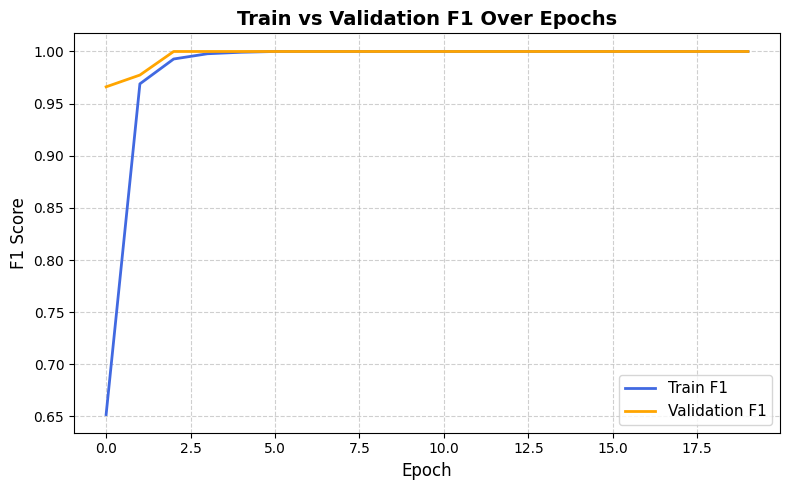

In [167]:
plt.figure(figsize=(8,5))
plt.plot(train_f1s, label='Train F1', color='royalblue', linewidth=2)
plt.plot(val_f1s, label='Validation F1', color='orange', linewidth=2)
plt.title('Train vs Validation F1 Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [153]:
# 10. Load best model and evaluate final test metrics
model.load_state_dict(torch.load("best_evse_model.pth"))
acc, prec, rec, f1, preds, trues = eval_model(model, test_loader)

print("\n✅ Final Test Set Evaluation:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")



✅ Final Test Set Evaluation:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


C:\Users\r\AppData\Local\Temp\ipykernel_26368\2810309738.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_evse_model.pth"))


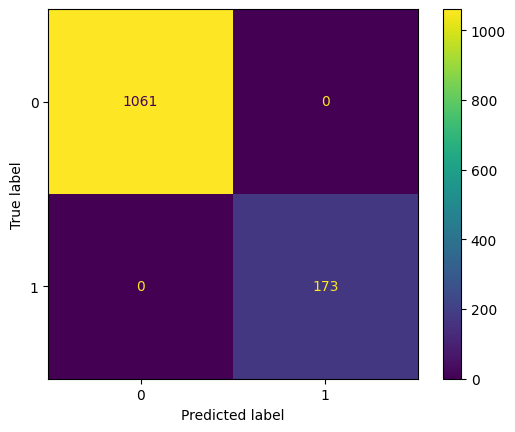

In [154]:
# 11. Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(trues, preds)
plt.show()


In [155]:
# (Optional) 12. Stratified K-Fold Cross-Validation similar to their code
print("\n=== Starting Stratified 5-Fold CV ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Scale inside fold
    scaler_fold = StandardScaler()
    X_train_fold = scaler_fold.fit_transform(X_train_fold)
    X_val_fold = scaler_fold.transform(X_val_fold)
    
    train_ds = EVSEDataset(X_train_fold, y_train_fold)
    val_ds = EVSEDataset(X_val_fold, y_val_fold)
    
    train_loader_fold = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader_fold = DataLoader(val_ds, batch_size=64)
    
    model_fold = HybridTransformerClassifier(input_dim=X.shape[1]).to(device)
    criterion_fold = nn.CrossEntropyLoss()
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=1e-3)
    
    best_f1_fold = 0
    best_model_state_fold = None
    train_f1s_fold = []
    val_f1s_fold = []

    for epoch in range(num_epochs):
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model_fold, optimizer_fold, criterion_fold, train_loader_fold)
        val_acc, val_prec, val_rec, val_f1, _, _ = eval_model(model_fold, val_loader_fold)
        print(f"Epoch {epoch+1}/{num_epochs} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        
        train_f1s_fold.append(train_f1)
        val_f1s_fold.append(val_f1)
        if val_f1 > best_f1_fold:
            best_f1_fold = val_f1
            best_model_state_fold = model_fold.state_dict()

    model_fold.load_state_dict(best_model_state_fold)
    acc, prec, rec, f1, _, _ = eval_model(model_fold, val_loader_fold)
    print(f"Fold {fold} Validation: Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")
    fold_metrics.append((acc, prec, rec, f1))
   
fold_metrics = np.array(fold_metrics)
print("\n=== Cross-Validation Results ===")
print(f"Accuracy:  {fold_metrics[:,0].mean():.4f} ± {fold_metrics[:,0].std():.4f}")
print(f"Precision: {fold_metrics[:,1].mean():.4f} ± {fold_metrics[:,1].std():.4f}")
print(f"Recall:    {fold_metrics[:,2].mean():.4f} ± {fold_metrics[:,2].std():.4f}")
print(f"F1-score:  {fold_metrics[:,3].mean():.4f} ± {fold_metrics[:,3].std():.4f}")


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Starting Stratified 5-Fold CV ===

--- Fold 1 ---
Epoch 1/20 | Train F1: 0.8598 | Val F1: 0.9598
Epoch 2/20 | Train F1: 0.9717 | Val F1: 0.9942
Epoch 3/20 | Train F1: 0.9921 | Val F1: 0.9971
Epoch 4/20 | Train F1: 0.9986 | Val F1: 0.9971
Epoch 5/20 | Train F1: 0.9993 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 0.9986 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.7431 | Val F1: 0.9575
Epoch 2/20 | Train F1: 0.9696 | Val F1: 0.9632
Epoch 3/20 | Train F1: 0.9885 | Val F1: 0.9971
Epoch 4/20 | Train F1: 0.9993 | Val F1: 0.9971
Epoch 5/20 | Train F1: 0.9993 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 0.9993 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 2 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.7516 | Val F1: 0.9575
Epoch 2/20 | Train F1: 0.9742 | Val F1: 0.9971
Epoch 3/20 | Train F1: 0.9971 | Val F1: 0.9942
Epoch 4/20 | Train F1: 0.9986 | Val F1: 0.9913
Epoch 5/20 | Train F1: 0.9978 | Val F1: 0.9913
Epoch 6/20 | Train F1: 0.9993 | Val F1: 0.9913
Epoch 7/20 | Train F1: 1.0000 | Val F1: 0.9913
Epoch 8/20 | Train F1: 0.9993 | Val F1: 0.9971
Epoch 9/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 10/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 11/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 12/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 13/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 14/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 15/20 | Train F1: 1.0000 | Val F1: 0.9942
Epoch 16/20 | Train F1: 1.0000 | Val F1: 0.9942
Epoch 17/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 18/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 19/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 20/20 | Train F1: 1.0000 | Val F1: 0.9942
Fold 3 Validation: Acc=0.9984 Prec=0.9942 Rec=0.9

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.6806 | Val F1: 0.9483
Epoch 2/20 | Train F1: 0.9689 | Val F1: 0.9661
Epoch 3/20 | Train F1: 0.9857 | Val F1: 0.9971
Epoch 4/20 | Train F1: 0.9964 | Val F1: 1.0000
Epoch 5/20 | Train F1: 0.9993 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 4 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.8571 | Val F1: 0.9774
Epoch 2/20 | Train F1: 0.9696 | Val F1: 0.9886
Epoch 3/20 | Train F1: 0.9957 | Val F1: 1.0000
Epoch 4/20 | Train F1: 0.9993 | Val F1: 1.0000
Epoch 5/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 5 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

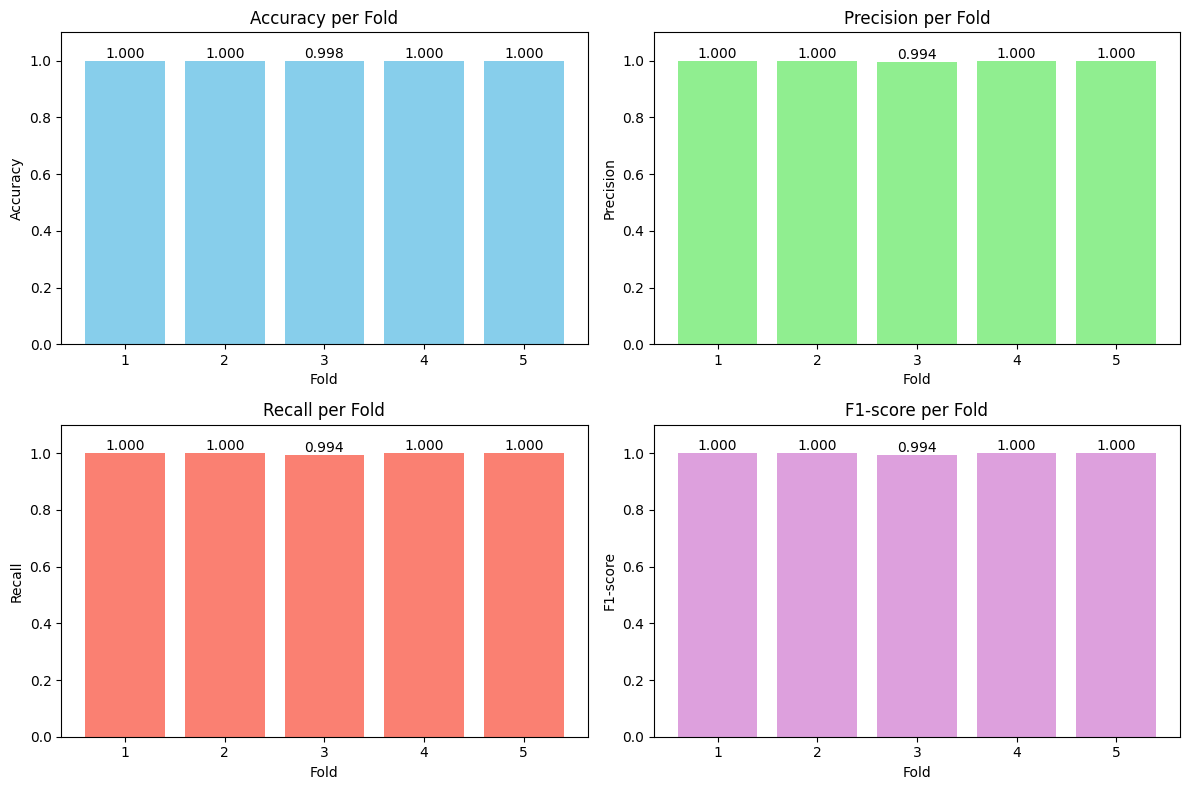

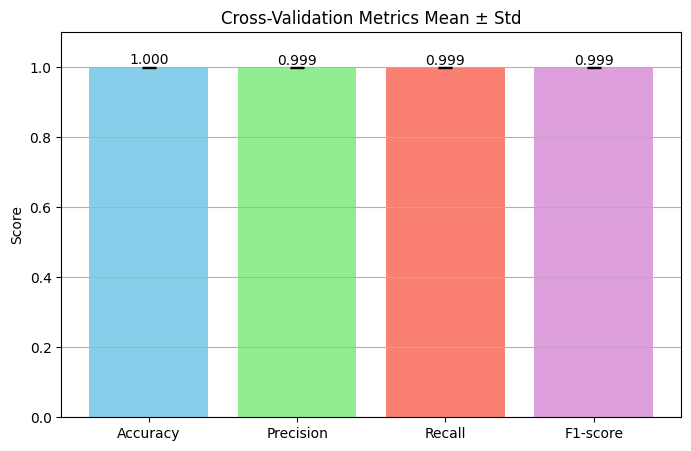

In [166]:
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
fold_indices = np.arange(1, len(fold_metrics)+1)

accs = fold_metrics[:, 0]
precs = fold_metrics[:, 1]
recs = fold_metrics[:, 2]
f1s = fold_metrics[:, 3]

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
bars = plt.bar(fold_indices, accs, color='skyblue')
plt.title('Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', 
             ha='center', va='bottom')

plt.subplot(2,2,2)
bars = plt.bar(fold_indices, precs, color='lightgreen')
plt.title('Precision per Fold')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.ylim(0,1.1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', 
             ha='center', va='bottom')

plt.subplot(2,2,3)
bars = plt.bar(fold_indices, recs, color='salmon')
plt.title('Recall per Fold')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.ylim(0,1.1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', 
             ha='center', va='bottom')

plt.subplot(2,2,4)
bars = plt.bar(fold_indices, f1s, color='plum')
plt.title('F1-score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1-score')
plt.ylim(0,1.1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Mean and Std bar plot
means = fold_metrics.mean(axis=0)
stds = fold_metrics.std(axis=0)

plt.figure(figsize=(8,5))
bars = plt.bar(metrics_names, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
plt.title('Cross-Validation Metrics Mean ± Std')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', 
             ha='center', va='bottom')

plt.show()


In [157]:
# Final Evaluation for Plotting
acc, prec, rec, f1, probs, true_labels = eval_model(model, test_loader)
print("\n✅ Final Test Evaluation:")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-score: {f1:.4f}")



✅ Final Test Evaluation:
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1-score: 1.0000


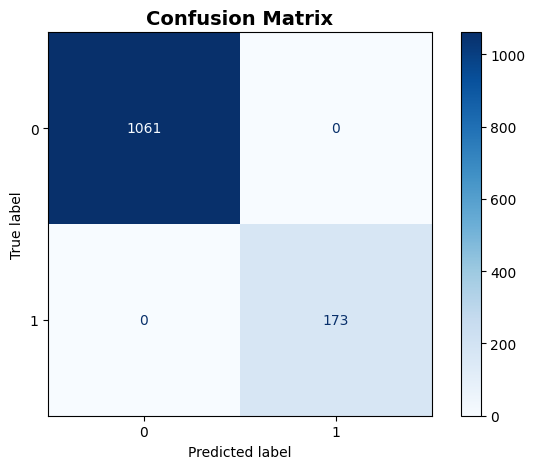

In [169]:
ConfusionMatrixDisplay.from_predictions(true_labels, probs > 0.5, cmap='Blues')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()


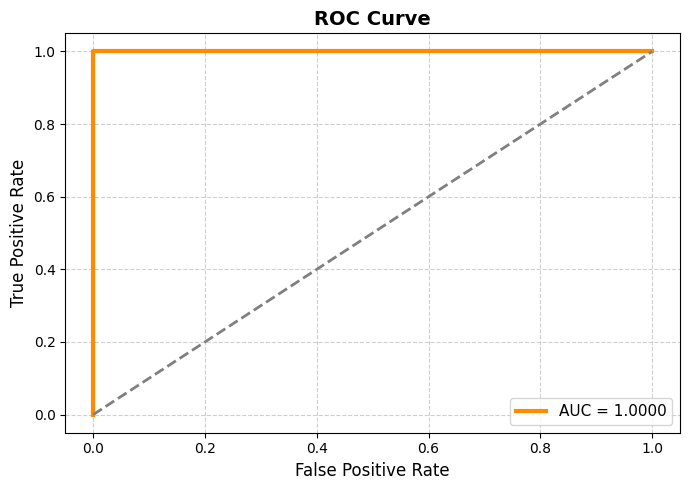

In [170]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='darkorange', linewidth=3)
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


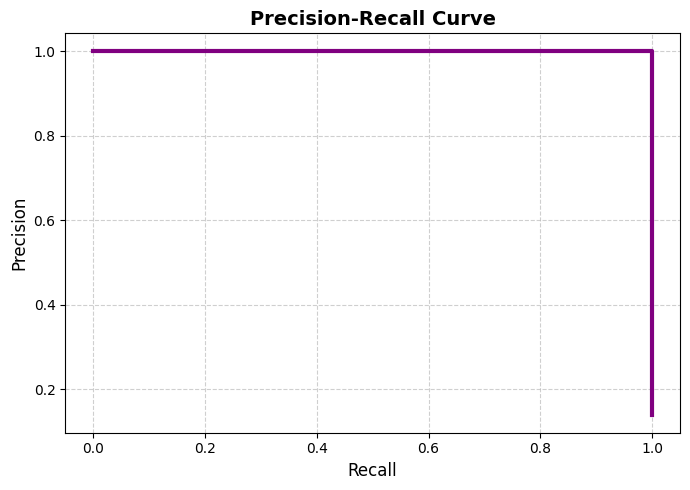

In [171]:
plt.figure(figsize=(7,5))
plt.plot(recall_vals, precision_vals, color='purple', linewidth=3)
plt.title("Precision-Recall Curve", fontsize=14, fontweight='bold')
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


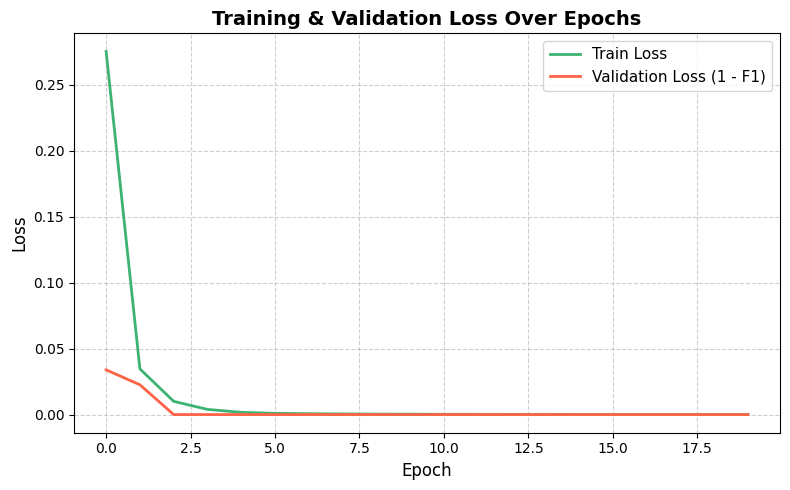

In [168]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", color='mediumseagreen', linewidth=2)
plt.plot(val_losses, label="Validation Loss (1 - F1)", color='tomato', linewidth=2)
plt.title("Training & Validation Loss Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
